In [32]:
def custom_boxeplot_grid(df, x, y_s, rename_dict):
    # data['Gene_length'] = data['Gene end (bp)'] - data['Gene start (bp)']
    # data['Transcript_length'] = data['Transcript end (bp)'] - data['Transcript start (bp)']
    data = df
    data = data.rename(rename_dict, axis=1)
    sns.set_context('paper', font_scale=1.5)


    x = x
    y_s = y_s

    # if len(x_s) > 3:


    f, ax = plt.subplots(ncols=len(y_s), figsize=(5*len(y_s), 7))

    for i, y in zip(range(len(y_s)), y_s):

        b = sns.boxenplot(data=data, x=x, y=y, ax=ax[i], showfliers=False)
        ymin = 0
        ymax = data[y].quantile(0.98)
        if 'GC'  in y:
            ymin = data[y].min()
            ymax = data[y].max()
        ax[i].set_ylim(ymin,ymax)

        ax[i].spines['right'].set_linewidth(0)
        ax[i].spines['top'].set_linewidth(0)

        medians = data[[x, y]].groupby([x])[y].median().sort_index(ascending=True)
        vertical_offset = data[y].median() * 0.05 # offset from median for display

        if medians[0] > 100:
            ratio = "+{}%".format(round(100 * round((max(medians) - min(medians)) / min(medians), 2), 0))
        else:
            ratio = "+{}".format(round(max(medians) - min(medians), 0))
        b.text(0.5, ymax/2, ratio, horizontalalignment='center',size='medium')


    
#     plt.ylabel('Exon length')
        ax[i].set_xlabel('')

        for j, xtick in enumerate(b.get_xticks()):
            if j <0:
                color='grey'
            else:
                color='w'
            b.text(xtick,medians[xtick] + vertical_offset,medians[xtick], 
                    horizontalalignment='center',size='medium',color=color,weight='semibold')

        add_stat_annotation(b, data=data, x=x, y=y, order= ['Single Isoform', 'Multi Isoform'],
                            box_pairs=[('Single Isoform', 'Multi Isoform')],
                            test='Mann-Whitney', text_format='star', loc='outside', verbose=2)
    #     print(data[[x, y]].drop_duplicates().pivot(columns='Gene_type', values='Length').describe())
    plt.tight_layout()

In [27]:
def custom_boxeplot(df, x, y_s, rename_dict):
    # data['Gene_length'] = data['Gene end (bp)'] - data['Gene start (bp)']
    # data['Transcript_length'] = data['Transcript end (bp)'] - data['Transcript start (bp)']
    data = df
    data = data.rename(rename_dict, axis=1)
    sns.set_context('paper', font_scale=1.5)


    x = x
    y_s = y_s

    # if len(x_s) > 3:


    f, ax = plt.subplots(ncols=len(y_s), figsize=(5*len(y_s), 7))

    for i, y in zip(range(len(y_s)), y_s):

        b = sns.boxenplot(data=data, x=x, y=y, showfliers=False)
        ymin = 0
        ymax = data[y].quantile(0.98)
        if 'GC'  in y:
            ymin = data[y].min()
            ymax = data[y].max()
        ax.set_ylim(ymin,ymax)

        ax.spines['right'].set_linewidth(0)
        ax.spines['top'].set_linewidth(0)

        medians = data[[x, y]].groupby([x])[y].median().sort_index(ascending=True)
        vertical_offset = data[y].median() * 0.05 # offset from median for display

        if medians[0] > 100:
            ratio = "+{}%".format(round(100 * round((max(medians) - min(medians)) / min(medians), 2), 0))
        else:
            ratio = "+{}".format(round(max(medians) - min(medians), 0))
        b.text(0.5, ymax/2, ratio, horizontalalignment='center',size='medium')


    
#     plt.ylabel('Exon length')
        ax.set_xlabel('')

        for j, xtick in enumerate(b.get_xticks()):
            if j <0:
                color='grey'
            else:
                color='w'
            b.text(xtick,medians[xtick] + vertical_offset,medians[xtick], 
                    horizontalalignment='center',size='medium',color=color,weight='semibold')

        add_stat_annotation(b, data=data, x=x, y=y, order= ['Single Isoform', 'Multi Isoform'],
                            box_pairs=[('Single Isoform', 'Multi Isoform')],
                            test='Mann-Whitney', text_format='star', loc='outside', verbose=2)
    #     print(data[[x, y]].drop_duplicates().pivot(columns='Gene_type', values='Length').describe())
    plt.tight_layout()

# Single VS Multi isoforms comparison

In [1]:
%config Completer.use_jedi = False

###### IMPORTS

In [2]:
import math
import os
import sys
import pandas as pd
sys.path.append("/home/weber/PycharmProjects/EXOTIC/src")
from statannot import add_stat_annotation

pd.options.mode.chained_assignment = None  # default='warn'
import multiprocessing
import parmap
import numpy as np
import collections
from tqdm import tqdm
import pandarallel
from pandarallel import pandarallel

pandarallel.initialize(nb_workers=20, progress_bar=True)
# tqdm.pandas()
from pprint import pprint
from scipy.stats import zscore
from scipy import stats

import requests
import re
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.colors as mc
from matplotlib.colors import LogNorm
import json
import matplotlib.ticker as mtick
from utils.utils import load_config_file

## YAML FILES CONFIG
yaml = load_config_file(config_file="/home/weber/PycharmProjects/EXOTIC/src/config.yaml")
exotic_files = yaml

import matplotlib.font_manager as font_manager

font_dirs = ['/home/weber/Fonts', ]
font_files = font_manager.findSystemFonts(fontpaths=font_dirs)
font_list = font_manager.createFontList(font_files)
font_manager.fontManager.ttflist.extend(font_list)

from matplotlib import rcParams
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Arial']
rcParams['font.weight'] = 'light'

INFO: Pandarallel will run on 20 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


/home/weber/.conda/envs/ExoCarto/lib/python3.7/site-packages/ipykernel_launcher.py:42: MatplotlibDeprecationWarning: 
The createFontList function was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use FontManager.addfont instead.


# ENSEMBL BIOMART GRCh38

In [35]:
biomart_path = "/gstock/EXOTIC/data/OTHERS/biomart_all.txt.gz"
biomart = pd.read_csv(biomart_path, compression='gzip', sep='\t', low_memory=False)
biomart = biomart.loc[(biomart['Gene type'] == 'protein_coding') & (biomart['Transcript type'] == 'protein_coding')]
biomart.columns

Index(['Gene stable ID', 'Transcript stable ID', 'Exon stable ID',
       'Gene start (bp)', 'Gene end (bp)', 'Transcript start (bp)',
       'Transcript end (bp)', 'Transcription start site (TSS)',
       'Transcript length (including UTRs and CDS)', 'Gene name',
       'Transcript name', 'Transcript count', 'Transcript type', 'Gene type',
       'Gene % GC content', 'APPRIS annotation',
       'Transcript support level (TSL)', 'Protein stable ID', 'HGNC ID',
       'UniProtKB/Swiss-Prot ID', 'RefSeq mRNA ID'],
      dtype='object')

In [7]:
biomart.head()

,Gene stable ID,Transcript stable ID,Exon stable ID,Gene start (bp),Gene end (bp),Transcript start (bp),Transcript end (bp),Transcription start site (TSS),Transcript length (including UTRs and CDS),Gene name,...,Transcript count,Transcript type,Gene type,Gene % GC content,APPRIS annotation,Transcript support level (TSL),Protein stable ID,HGNC ID,UniProtKB/Swiss-Prot ID,RefSeq mRNA ID
0,ENSG00000198888,ENST00000361390,ENSE00001435714,3307,4262,3307,4262,3307,956,MT-ND1,...,1,protein_coding,protein_coding,47.70,principal1,tslNA,ENSP00000354687,HGNC:7455,P03886,NaN
1,ENSG00000198763,ENST00000361453,ENSE00001435686,4470,5511,4470,5511,4470,1042,MT-ND2,...,1,protein_coding,protein_coding,42.99,principal1,tslNA,ENSP00000355046,HGNC:7456,P03891,NaN
2,ENSG00000198804,ENST00000361624,ENSE00001435647,5904,7445,5904,7445,5904,1542,MT-CO1,...,1,protein_coding,protein_coding,46.24,principal1,tslNA,ENSP00000354499,HGNC:7419,P00395,NaN
3,ENSG00000198712,ENST00000361739,ENSE00001435613,7586,8269,7586,8269,7586,684,MT-CO2,...,1,protein_coding,protein_coding,46.20,principal1,tslNA,ENSP00000354876,HGNC:7421,P00403,NaN
4,ENSG00000228253,ENST00000361851,ENSE00001435286,8366,8572,8366,8572,8366,207,MT-ATP8,...,1,protein_coding,protein_coding,39.61,principal1,tslNA,ENSP00000355265,HGNC:7415,P03928,NaN


## Export for sQTLs analysis


In [172]:
biomart_gb_gene.to_csv('/gstock/EXOTIC/data/OTHERS/biomart_mi_si.csv.gz', compression='gzip', sep='\t', index=False)

## Genes count

In [36]:
biomart_gb_gene = biomart.groupby(['Gene stable ID'])['Transcript stable ID'].nunique().reset_index()
biomart_gb_gene.loc[biomart_gb_gene['Transcript stable ID'] == 1, 'Gene_type'] = 'Single Isoform'
biomart_gb_gene.loc[biomart_gb_gene['Transcript stable ID'] > 1, 'Gene_type'] = 'Multi Isoform'
biomart_gb_gene.columns = ['Gene stable ID', 'Transcript_count', 'Gene_type']
biomart_gb_gene['Gene_type'].value_counts()

Multi Isoform     17221
Single Isoform     5271
Name: Gene_type, dtype: int64

In [60]:
biomart_gb_gene = biomart.groupby(['Gene name'])['Transcript stable ID'].nunique().reset_index()
biomart_gb_gene.loc[biomart_gb_gene['Transcript stable ID'] == 1, 'Gene_type'] = 'Single Isoform'
biomart_gb_gene.loc[biomart_gb_gene['Transcript stable ID'] > 1, 'Gene_type'] = 'Multi Isoform'
biomart_gb_gene.columns = ['Gene name', 'Transcript_count', 'Gene_type']
biomart_gb_gene['Gene_type'].value_counts()

Multi Isoform     15759
Single Isoform     4187
Name: Gene_type, dtype: int64

In [62]:
biomart_gb_gene[['Gene name', 'Gene_type']].to_excel('/gstock/EXOTIC/data/GENOMICS/Ensembl_GRCh38_MI_SI.xlsx')

## Transcripts count

In [37]:
biomart_gb_transcript = biomart.groupby(['Gene stable ID', 'Transcript stable ID'])['Exon stable ID'].nunique().reset_index()
biomart_gb_transcript.head()

,Gene stable ID,Transcript stable ID,Exon stable ID
0,ENSG00000000003,ENST00000373020,8
1,ENSG00000000003,ENST00000612152,7
2,ENSG00000000003,ENST00000614008,7
3,ENSG00000000005,ENST00000373031,7
4,ENSG00000000419,ENST00000371582,10


## Merge tmp DF

In [38]:
merge = pd.merge(
    pd.merge(biomart_gb_gene, biomart_gb_transcript, on='Gene stable ID'),
    biomart[['Gene stable ID', 'Transcript stable ID', 'Gene start (bp)', 'Gene end (bp)', 'Transcript start (bp)',
       'Transcript end (bp)', 'Transcript length (including UTRs and CDS)', 'Gene % GC content']].drop_duplicates(),
    left_on=['Gene stable ID', 'Transcript stable ID'],
    right_on=['Gene stable ID', 'Transcript stable ID']
)
merge.head()

,Gene stable ID,Transcript_count,Gene_type,Transcript stable ID,Exon stable ID,Gene start (bp),Gene end (bp),Transcript start (bp),Transcript end (bp),Transcript length (including UTRs and CDS),Gene % GC content
0,ENSG00000000003,3,Multi Isoform,ENST00000373020,8,100627108,100639991,100627108,100636806,3768,40.40
1,ENSG00000000003,3,Multi Isoform,ENST00000612152,7,100627108,100639991,100627109,100637104,3796,40.40
2,ENSG00000000003,3,Multi Isoform,ENST00000614008,7,100627108,100639991,100632063,100637104,900,40.40
3,ENSG00000000005,1,Single Isoform,ENST00000373031,7,100584936,100599885,100584936,100599885,1205,40.78
4,ENSG00000000419,4,Multi Isoform,ENST00000371582,10,50934867,50958555,50934867,50958555,1161,39.85


p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

Single Isoform v.s. Multi Isoform: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=0.000e+00 U_stat=1.083e+08
p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

Single Isoform v.s. Multi Isoform: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=7.672e-81 U_stat=2.744e+08
p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

Single Isoform v.s. Multi Isoform: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=0.000e+00 U_stat=1.525e+08
p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e

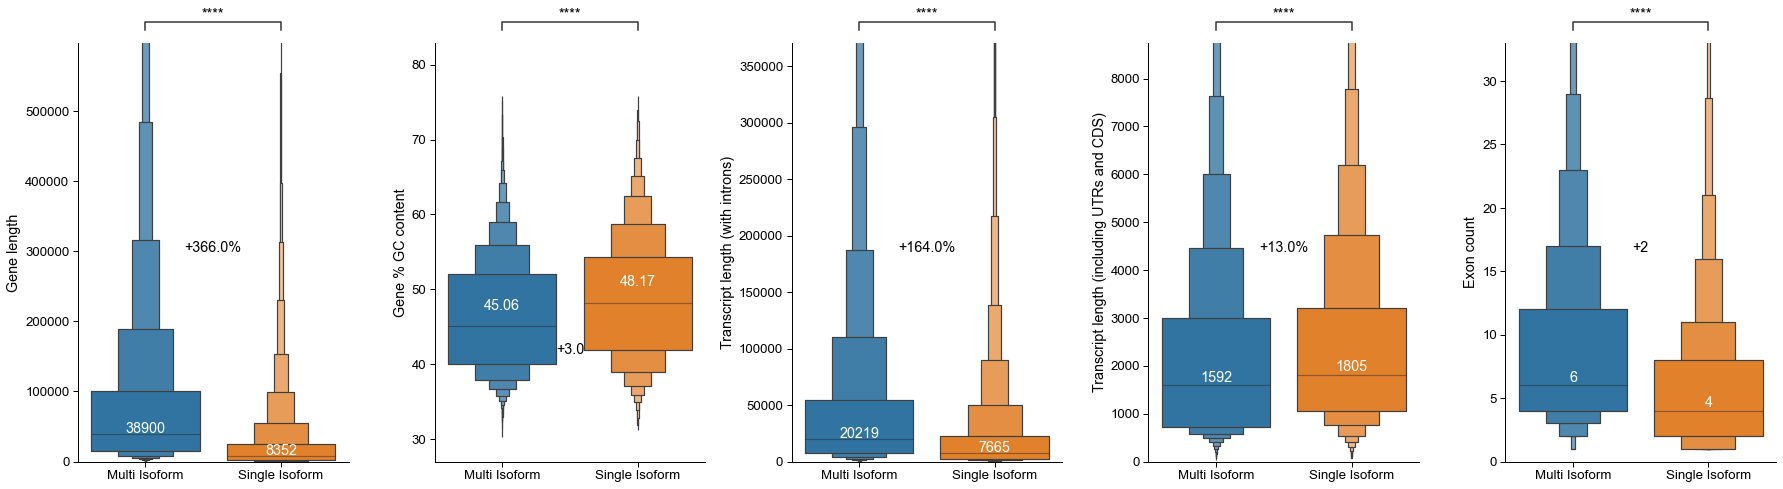

In [39]:
data = merge.sort_values(by='Gene_type', ascending=True)
data['Gene_length'] = data['Gene end (bp)'] - data['Gene start (bp)']
data['Transcript_length'] = data['Transcript end (bp)'] - data['Transcript start (bp)']

custom_boxeplot_grid(data, 'Gene_type', 
                     ['Gene length', 'Gene % GC content', 'Transcript length (with introns)', 'Transcript length (including UTRs and CDS)',  'Exon count'], 
                    {
            'Gene_length' : 'Gene length',
            'Transcript_length' : 'Transcript length (with introns)',
            'Exon stable ID' : 'Exon count'
        }
                    )


# RefSeq corrected (GRCh37)

# All RefSeq GRCh37 & GRCh38

## RefSeq 37

In [47]:
refseq_37 = pd.read_csv('/gstock/EXOTIC/data/GENOMICS/GRCh37_RefSeq_lite_hgnc.csv.gz', compression='gzip', sep='\t')
refseq_37.loc[refseq_37['mRNA_nb'] > 1, 'Gene_type'] = 'Multi Isoform'
refseq_37.loc[refseq_37['mRNA_nb'] == 1, 'Gene_type'] = 'Single Isoform'
refseq_37

,ID,Source,Element,Start,End,Score,Brin,Phase,CCDS,Dbxref,...,CDS_num,mRNA_num,mRNA_nb,Count,Count_CDS_alternative,Count_CDS_constitutive,mRNA_IDS,CDS_locations_corrected,HGNC,Gene_type
0,NC_000019.9,BestRefSeq,gene,58856549,58864858,.,-,.,NaN,"GeneID:1,HGNC:HGNC:5,MIM:138670",...,NaN,NaN,1,NaN,0,8,['NM_130786.4'],"{(58858388, 58858395): {'Sources': [(58858388,...",5.0,Single Isoform
1,NC_000008.10,BestRefSeq,gene,18248792,18258728,.,+,.,NaN,"GeneID:10,HGNC:HGNC:7646,MIM:612182",...,NaN,NaN,1,NaN,0,1,['NM_000015.3'],"{(18257514, 18258386): {'Sources': [(18257514,...",7646.0,Single Isoform
2,NC_000020.10,BestRefSeq,gene,43248160,43280399,.,-,.,NaN,"GeneID:100,HGNC:HGNC:186,MIM:608958",...,NaN,NaN,3,NaN,7,6,"['NM_001322050.1', 'NM_001322051.1', 'NM_00002...","{(43248475, 43248488): {'Sources': [(43248475,...",186.0,Multi Isoform
3,NC_000018.9,BestRefSeq,gene,25530930,25757094,.,-,.,NaN,"GeneID:1000,HGNC:HGNC:1759,MIM:114020",...,NaN,NaN,2,NaN,3,14,"['NM_001792.5', 'NM_001308176.2']","{(25532117, 25532323): {'Sources': [(25532117,...",1759.0,Multi Isoform
4,NC_000001.10,BestRefSeq,gene,243651535,244014381,.,-,.,NaN,"GeneID:10000,HGNC:HGNC:393,MIM:611223",...,NaN,NaN,4,NaN,2,12,"['NM_181690.2', 'NM_001206729.1', 'NM_00137007...","{(243663045, 243663088): {'Sources': [(2436630...",393.0,Multi Isoform
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19318,NC_000009.11,BestRefSeq,gene,114979995,115095944,.,-,.,NaN,"GeneID:9991,HGNC:HGNC:10253,MIM:607527",...,NaN,NaN,6,NaN,10,10,"['NM_001163790.2', 'NM_001244896.2', 'NM_00124...","{(114982452, 114982653): {'Sources': [(1149824...",10253.0,Multi Isoform
19319,NC_000021.8,BestRefSeq,gene,35736323,35743440,.,+,.,NaN,"GeneID:9992,HGNC:HGNC:6242,MIM:603796",...,NaN,NaN,1,NaN,0,1,['NM_172201.1'],"{(35742778, 35743149): {'Sources': [(35742778,...",6242.0,Single Isoform
19320,NC_000022.10,BestRefSeq,gene,19023795,19109967,.,-,.,NaN,"GeneID:9993,HGNC:HGNC:2845,MIM:600594",...,NaN,NaN,4,NaN,3,8,"['NM_001173533.1', 'NM_001173534.2', 'NM_00118...","{(19026378, 19026634): {'Sources': [(19026378,...",2845.0,Multi Isoform
19321,NC_000006.11,BestRefSeq,gene,90539599,90584155,.,+,.,NaN,"GeneID:9994,HGNC:HGNC:1510,MIM:606880",...,NaN,NaN,3,NaN,0,9,"['NM_012115.4', 'NM_001137667.2', 'NM_00113766...","{(90556309, 90556363): {'Sources': [(90556309,...",1510.0,Multi Isoform


## Genes count

In [261]:
refseq_37['Gene_type'].value_counts()

Multi Isoform     10960
Single Isoform     8363
Name: Gene_type, dtype: int64

## RefSeq 38

In [48]:
refseq_38 = pd.read_parquet('/gstock/EXOTIC/data/GENOMICS/RefSeq_38_precomputed.parquet')
refseq_38 = refseq_38[[c for c in refseq_38.columns if 'Bin' not in c]]
refseq_38['Exon_length'] = refseq_38['Exon_list'].apply(lambda r: [int(e.split('_')[1]) - int(e.split('_')[0]) for e in r])
refseq_38['Intron_length'] = refseq_38['Intron_list'].apply(lambda r: [int(e.split('_')[1]) - int(e.split('_')[0]) for e in r])
refseq_38['Intron_pct'] = refseq_38['Intron_size_total'].rank(pct=True)
refseq_38 = refseq_38.loc[(refseq_38['Intron_pct'] <= 0.95) & (refseq_38['Intron_size_total'] > 0)]
refseq_38['Exon_count'] = refseq_38['Exon_list'].apply(len)
refseq_38['Intron_count'] = refseq_38['Intron_list'].apply(len)
refseq_38.head()

,CHROM,Gene_start_end,Exon_list,5_prime_UTR,3_prime_UTR,Intron_list,Exon_size_total,Intron_size_total,Gene_body_size,5_prime_UTR_size,3_prime_UTR_size,BED_boundaries_for_hail_10kbp_added,Exon_length,Intron_length,Intron_pct,Exon_count,Intron_count
A1BG,2,58345183_58353492,"[58347022_58347029, 58347353_58347640, 5835037...",58345183_58347021,58353438_58353492,"[58347030_58347352, 58347641_58350369, 5835065...",1480,4921,8309,1838,54,chr2:58340183-58358492,"[7, 287, 281, 296, 272, 269, 35, 33]","[322, 2728, 738, 594, 371, 93, 75]",0.251844,8,7
A1CF,1,50799409_50885666,"[50806729_50806880, 50809894_50810042, 5081104...",50799409_50806728,50859941_50885666,"[50806881_50809893, 50810043_50811039, 5081117...",1896,51293,86257,7319,25725,chr1:50794409-50890666,"[151, 148, 136, 205, 273, 97, 164, 238, 130, 1...","[3012, 996, 2679, 1942, 4271, 7480, 7777, 5548...",0.702997,12,11
A2M,2,9067708_9116229,"[9067823_9067839, 9068183_9068224, 9068740_906...",9067708_9067822,9115850_9116229,"[9067840_9068182, 9068225_9068739, 9068843_906...",4389,43567,48521,114,379,chr2:9062708-9121229,"[16, 41, 102, 68, 90, 127, 218, 223, 180, 74, ...","[342, 514, 901, 673, 1779, 165, 1687, 1971, 40...",0.671636,36,35
A2ML1,2,8822554_8887202,"[8822652_8822713, 8823182_8823365, 8823720_882...",8822554_8822651,8875012_8887202,"[8822714_8823181, 8823366_8823719, 8823883_882...",4332,47957,64648,97,12190,chr2:8817554-8892202,"[61, 183, 162, 52, 20, 159, 84, 126, 114, 109,...","[467, 353, 5843, 4881, 823, 587, 1099, 768, 66...",0.689741,36,35
A3GALT2,1,33306766_33321098,"[33306766_33307453, 33312052_33312189, 3331250...",33306766_33306765,33321099_33321098,"[33307454_33312051, 33312190_33312500, 3331259...",1018,13306,14332,-1,-1,chr1:33301766-33326098,"[687, 137, 89, 83, 22]","[4597, 310, 215, 8184]",0.419069,5,4


## Tmp merge to retrieve SI & MI

In [50]:
refseq = pd.merge(refseq_37.set_index('Name')[['Gene_type']], refseq_38, left_index=True, right_index=True)
refseq.head()

,Gene_type,CHROM,Gene_start_end,Exon_list,5_prime_UTR,3_prime_UTR,Intron_list,Exon_size_total,Intron_size_total,Gene_body_size,5_prime_UTR_size,3_prime_UTR_size,BED_boundaries_for_hail_10kbp_added,Exon_length,Intron_length,Intron_pct,Exon_count,Intron_count
A1BG,Single Isoform,2,58345183_58353492,"[58347022_58347029, 58347353_58347640, 5835037...",58345183_58347021,58353438_58353492,"[58347030_58347352, 58347641_58350369, 5835065...",1480,4921,8309,1838,54,chr2:58340183-58358492,"[7, 287, 281, 296, 272, 269, 35, 33]","[322, 2728, 738, 594, 371, 93, 75]",0.251844,8,7
A1CF,Multi Isoform,1,50799409_50885666,"[50806729_50806880, 50809894_50810042, 5081104...",50799409_50806728,50859941_50885666,"[50806881_50809893, 50810043_50811039, 5081117...",1896,51293,86257,7319,25725,chr1:50794409-50890666,"[151, 148, 136, 205, 273, 97, 164, 238, 130, 1...","[3012, 996, 2679, 1942, 4271, 7480, 7777, 5548...",0.702997,12,11
A2M,Multi Isoform,2,9067708_9116229,"[9067823_9067839, 9068183_9068224, 9068740_906...",9067708_9067822,9115850_9116229,"[9067840_9068182, 9068225_9068739, 9068843_906...",4389,43567,48521,114,379,chr2:9062708-9121229,"[16, 41, 102, 68, 90, 127, 218, 223, 180, 74, ...","[342, 514, 901, 673, 1779, 165, 1687, 1971, 40...",0.671636,36,35
A2ML1,Multi Isoform,2,8822554_8887202,"[8822652_8822713, 8823182_8823365, 8823720_882...",8822554_8822651,8875012_8887202,"[8822714_8823181, 8823366_8823719, 8823883_882...",4332,47957,64648,97,12190,chr2:8817554-8892202,"[61, 183, 162, 52, 20, 159, 84, 126, 114, 109,...","[467, 353, 5843, 4881, 823, 587, 1099, 768, 66...",0.689741,36,35
A3GALT2,Single Isoform,1,33306766_33321098,"[33306766_33307453, 33312052_33312189, 3331250...",33306766_33306765,33321099_33321098,"[33307454_33312051, 33312190_33312500, 3331259...",1018,13306,14332,-1,-1,chr1:33301766-33326098,"[687, 137, 89, 83, 22]","[4597, 310, 215, 8184]",0.419069,5,4


p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

Single Isoform v.s. Multi Isoform: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=7.503e-156 U_stat=2.403e+07
p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

Single Isoform v.s. Multi Isoform: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=2.633e-68 U_stat=2.672e+07
p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

Single Isoform v.s. Multi Isoform: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=4.806e-68 U_stat=2.673e+07
p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00

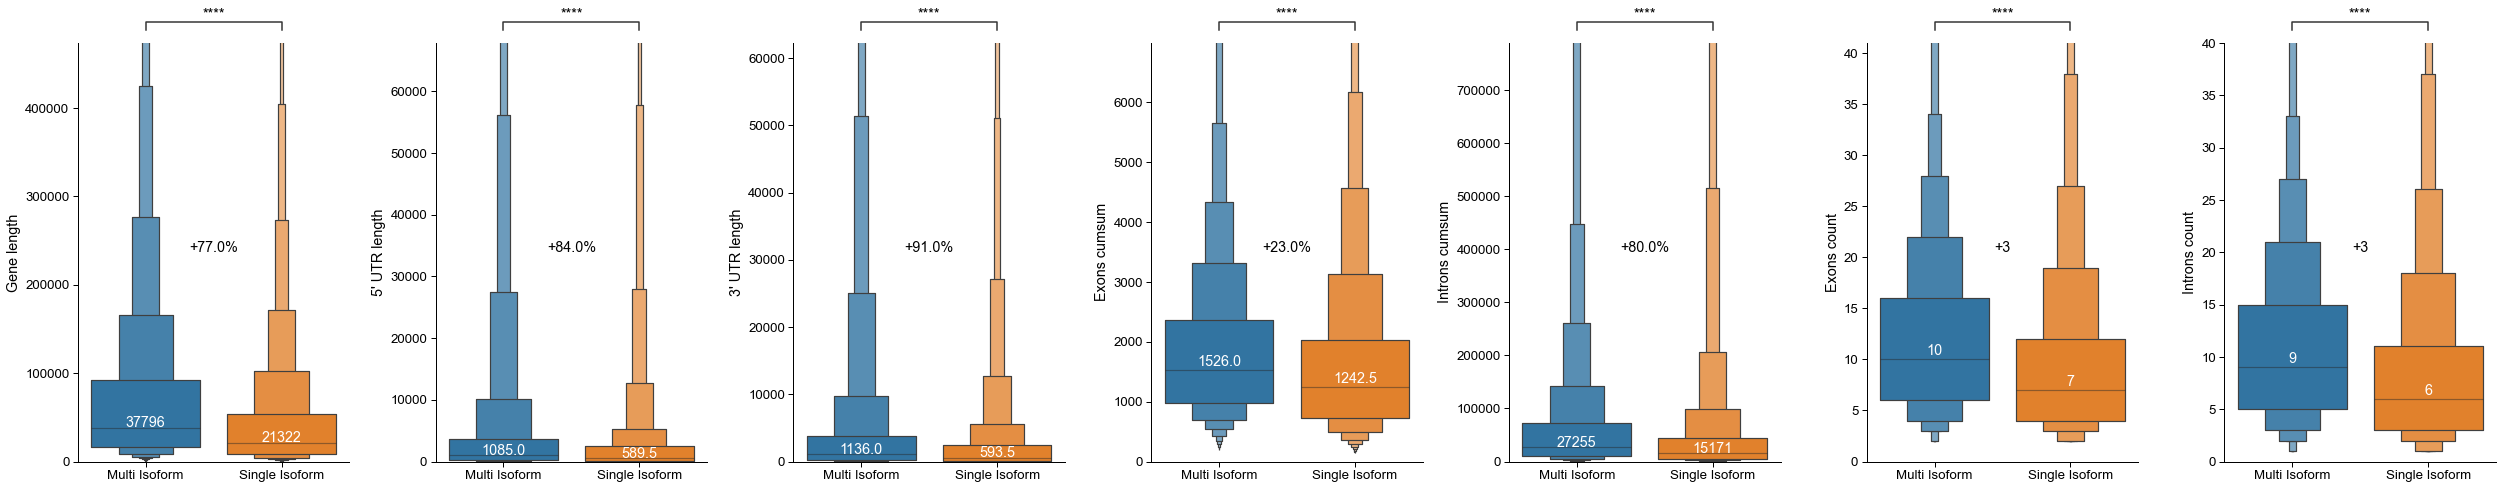

In [51]:
data = refseq.sort_values(by='Gene_type', ascending=True)

x_s = 'Gene_type'
y_s = ['Gene length', "5' UTR length", "3' UTR length", 'Exons cumsum', 'Introns cumsum', 'Exons count', 'Introns count']

rename_dict = {
    'Gene_body_size' : 'Gene length',
    '5_prime_UTR_size' : "5' UTR length",
    '3_prime_UTR_size' : "3' UTR length",
    'Exon_size_total' : 'Exons cumsum',
    'Intron_size_total' : 'Introns cumsum',
    'Exon_count' : "Exons count",
    'Intron_count' : "Introns count"
}

custom_boxeplot_grid(data, x_s, y_s, rename_dict)


p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

Single Isoform v.s. Multi Isoform: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.868e-105 U_stat=3.158e+09


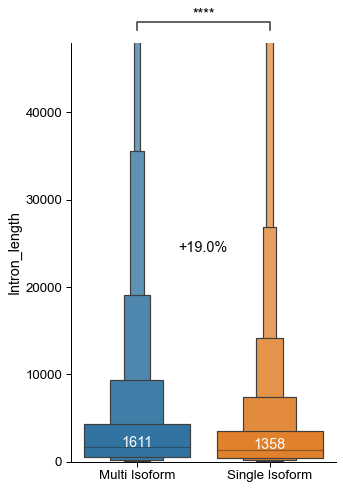

In [52]:
import numpy as np
data = refseq.sort_values(by='Gene_type', ascending=True)
data = data.reset_index()[['Gene_type', 'index', 'Intron_length']].explode('Intron_length').dropna()
data = data.replace([np.inf, -np.inf], np.nan)

x_s = 'Gene_type'
y_s = ['Intron_length']

custom_boxeplot(data, x_s, y_s, {})


p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

Single Isoform v.s. Multi Isoform: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=4.845e-115 U_stat=4.324e+09


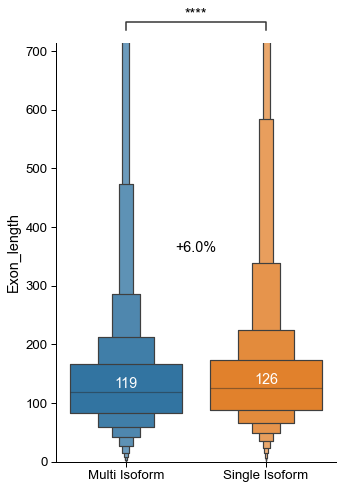

In [53]:
import numpy as np
data = refseq.sort_values(by='Gene_type', ascending=True)
data = data.reset_index()[['Gene_type', 'index', 'Exon_length']].explode('Exon_length').dropna()
data = data.replace([np.inf, -np.inf], np.nan)

x_s = 'Gene_type'
y_s = ['Exon_length']

    
custom_boxeplot(data, x_s, y_s, {})


# After correction

In [54]:
refseq_38.head()

,CHROM,Gene_start_end,Exon_list,5_prime_UTR,3_prime_UTR,Intron_list,Exon_size_total,Intron_size_total,Gene_body_size,5_prime_UTR_size,3_prime_UTR_size,BED_boundaries_for_hail_10kbp_added,Exon_length,Intron_length,Intron_pct,Exon_count,Intron_count
A1BG,2,58345183_58353492,"[58347022_58347029, 58347353_58347640, 5835037...",58345183_58347021,58353438_58353492,"[58347030_58347352, 58347641_58350369, 5835065...",1480,4921,8309,1838,54,chr2:58340183-58358492,"[7, 287, 281, 296, 272, 269, 35, 33]","[322, 2728, 738, 594, 371, 93, 75]",0.251844,8,7
A1CF,1,50799409_50885666,"[50806729_50806880, 50809894_50810042, 5081104...",50799409_50806728,50859941_50885666,"[50806881_50809893, 50810043_50811039, 5081117...",1896,51293,86257,7319,25725,chr1:50794409-50890666,"[151, 148, 136, 205, 273, 97, 164, 238, 130, 1...","[3012, 996, 2679, 1942, 4271, 7480, 7777, 5548...",0.702997,12,11
A2M,2,9067708_9116229,"[9067823_9067839, 9068183_9068224, 9068740_906...",9067708_9067822,9115850_9116229,"[9067840_9068182, 9068225_9068739, 9068843_906...",4389,43567,48521,114,379,chr2:9062708-9121229,"[16, 41, 102, 68, 90, 127, 218, 223, 180, 74, ...","[342, 514, 901, 673, 1779, 165, 1687, 1971, 40...",0.671636,36,35
A2ML1,2,8822554_8887202,"[8822652_8822713, 8823182_8823365, 8823720_882...",8822554_8822651,8875012_8887202,"[8822714_8823181, 8823366_8823719, 8823883_882...",4332,47957,64648,97,12190,chr2:8817554-8892202,"[61, 183, 162, 52, 20, 159, 84, 126, 114, 109,...","[467, 353, 5843, 4881, 823, 587, 1099, 768, 66...",0.689741,36,35
A3GALT2,1,33306766_33321098,"[33306766_33307453, 33312052_33312189, 3331250...",33306766_33306765,33321099_33321098,"[33307454_33312051, 33312190_33312500, 3331259...",1018,13306,14332,-1,-1,chr1:33301766-33326098,"[687, 137, 89, 83, 22]","[4597, 310, 215, 8184]",0.419069,5,4


In [5]:
refseq_corrected_by_gtex = pd.read_parquet('/gstock/EXOTIC/data/GENOMICS/RefSeq_corrected_by_GTEx_lite.parquet')
refseq_corrected_by_gtex.loc[refseq_corrected_by_gtex['new_mRNA_nb_total'] == 1, 'Gene_type'] = 'Single Isoform'
refseq_corrected_by_gtex.loc[refseq_corrected_by_gtex['new_mRNA_nb_total'] > 1, 'Gene_type'] = 'Multi Isoform'
refseq_corrected_by_gtex['Length'] = refseq_corrected_by_gtex['End'] - refseq_corrected_by_gtex['Start']
refseq_corrected_by_gtex.head()

,Gene,ranges,new_mRNA_exons,new_mRNA_nb,new_mRNA_gene,new_mRNA_nb_total,new_Ratio,new_Ratio_num,Const_Alt,new_Ratio_num_bins,Start,End,Length,new_CDS_count,Gene_type
0,A2M,9220419-9220435,"[NM_001347423, NM_001347425, NM_000014, NM_001...",4,"[NM_001347423, NM_001347425, NM_000014, NM_001...",4,4/4,1.0,Const,0.8 - 1,9220419,9220435,16,38,Multi Isoform
1,A2M,9220779-9220820,"[NM_001347423, NM_001347425, NM_000014, NM_001...",4,"[NM_001347423, NM_001347425, NM_000014, NM_001...",4,4/4,1.0,Const,0.8 - 1,9220779,9220820,41,38,Multi Isoform
2,A2M,9221336-9221438,"[NM_001347423, NM_001347425, NM_000014, NM_001...",4,"[NM_001347423, NM_001347425, NM_000014, NM_001...",4,4/4,1.0,Const,0.8 - 1,9221336,9221438,102,38,Multi Isoform
3,A2M,9222341-9222409,"[NM_001347423, NM_001347425, NM_000014, NM_001...",4,"[NM_001347423, NM_001347425, NM_000014, NM_001...",4,4/4,1.0,Const,0.8 - 1,9222341,9222409,68,38,Multi Isoform
4,A2M,9223084-9223174,"[NM_001347423, NM_001347425, NM_000014, NM_001...",4,"[NM_001347423, NM_001347425, NM_000014, NM_001...",4,4/4,1.0,Const,0.8 - 1,9223084,9223174,90,38,Multi Isoform


In [57]:
refseq_corrected_full_info = pd.merge(refseq_38.reset_index(), refseq_corrected_by_gtex[['Gene', 'Gene_type']], left_on='index', right_on='Gene')
refseq_corrected_full_info.head()


,index,CHROM,Gene_start_end,Exon_list,5_prime_UTR,3_prime_UTR,Intron_list,Exon_size_total,Intron_size_total,Gene_body_size,5_prime_UTR_size,3_prime_UTR_size,BED_boundaries_for_hail_10kbp_added,Exon_length,Intron_length,Intron_pct,Exon_count,Intron_count,Gene,Gene_type
0,A2M,2,9067708_9116229,"[9067823_9067839, 9068183_9068224, 9068740_906...",9067708_9067822,9115850_9116229,"[9067840_9068182, 9068225_9068739, 9068843_906...",4389,43567,48521,114,379,chr2:9062708-9121229,"[16, 41, 102, 68, 90, 127, 218, 223, 180, 74, ...","[342, 514, 901, 673, 1779, 165, 1687, 1971, 40...",0.671636,36,35,A2M,Multi Isoform
1,A2M,2,9067708_9116229,"[9067823_9067839, 9068183_9068224, 9068740_906...",9067708_9067822,9115850_9116229,"[9067840_9068182, 9068225_9068739, 9068843_906...",4389,43567,48521,114,379,chr2:9062708-9121229,"[16, 41, 102, 68, 90, 127, 218, 223, 180, 74, ...","[342, 514, 901, 673, 1779, 165, 1687, 1971, 40...",0.671636,36,35,A2M,Multi Isoform
2,A2M,2,9067708_9116229,"[9067823_9067839, 9068183_9068224, 9068740_906...",9067708_9067822,9115850_9116229,"[9067840_9068182, 9068225_9068739, 9068843_906...",4389,43567,48521,114,379,chr2:9062708-9121229,"[16, 41, 102, 68, 90, 127, 218, 223, 180, 74, ...","[342, 514, 901, 673, 1779, 165, 1687, 1971, 40...",0.671636,36,35,A2M,Multi Isoform
3,A2M,2,9067708_9116229,"[9067823_9067839, 9068183_9068224, 9068740_906...",9067708_9067822,9115850_9116229,"[9067840_9068182, 9068225_9068739, 9068843_906...",4389,43567,48521,114,379,chr2:9062708-9121229,"[16, 41, 102, 68, 90, 127, 218, 223, 180, 74, ...","[342, 514, 901, 673, 1779, 165, 1687, 1971, 40...",0.671636,36,35,A2M,Multi Isoform
4,A2M,2,9067708_9116229,"[9067823_9067839, 9068183_9068224, 9068740_906...",9067708_9067822,9115850_9116229,"[9067840_9068182, 9068225_9068739, 9068843_906...",4389,43567,48521,114,379,chr2:9062708-9121229,"[16, 41, 102, 68, 90, 127, 218, 223, 180, 74, ...","[342, 514, 901, 673, 1779, 165, 1687, 1971, 40...",0.671636,36,35,A2M,Multi Isoform


## Genes count

In [6]:
print(refseq_corrected_by_gtex.Gene.nunique())
print(refseq_corrected_by_gtex.loc[refseq_corrected_by_gtex['new_mRNA_nb_total'] == 1].Gene.nunique())
print(refseq_corrected_by_gtex.loc[refseq_corrected_by_gtex['new_mRNA_nb_total'] > 1].Gene.nunique())

15352
7173
8179


p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

Single Isoform v.s. Multi Isoform: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.551e-47 U_stat=2.004e+07
p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

Single Isoform v.s. Multi Isoform: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.669e-35 U_stat=2.051e+07
p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

Single Isoform v.s. Multi Isoform: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=7.647e-26 U_stat=2.096e+07
p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e

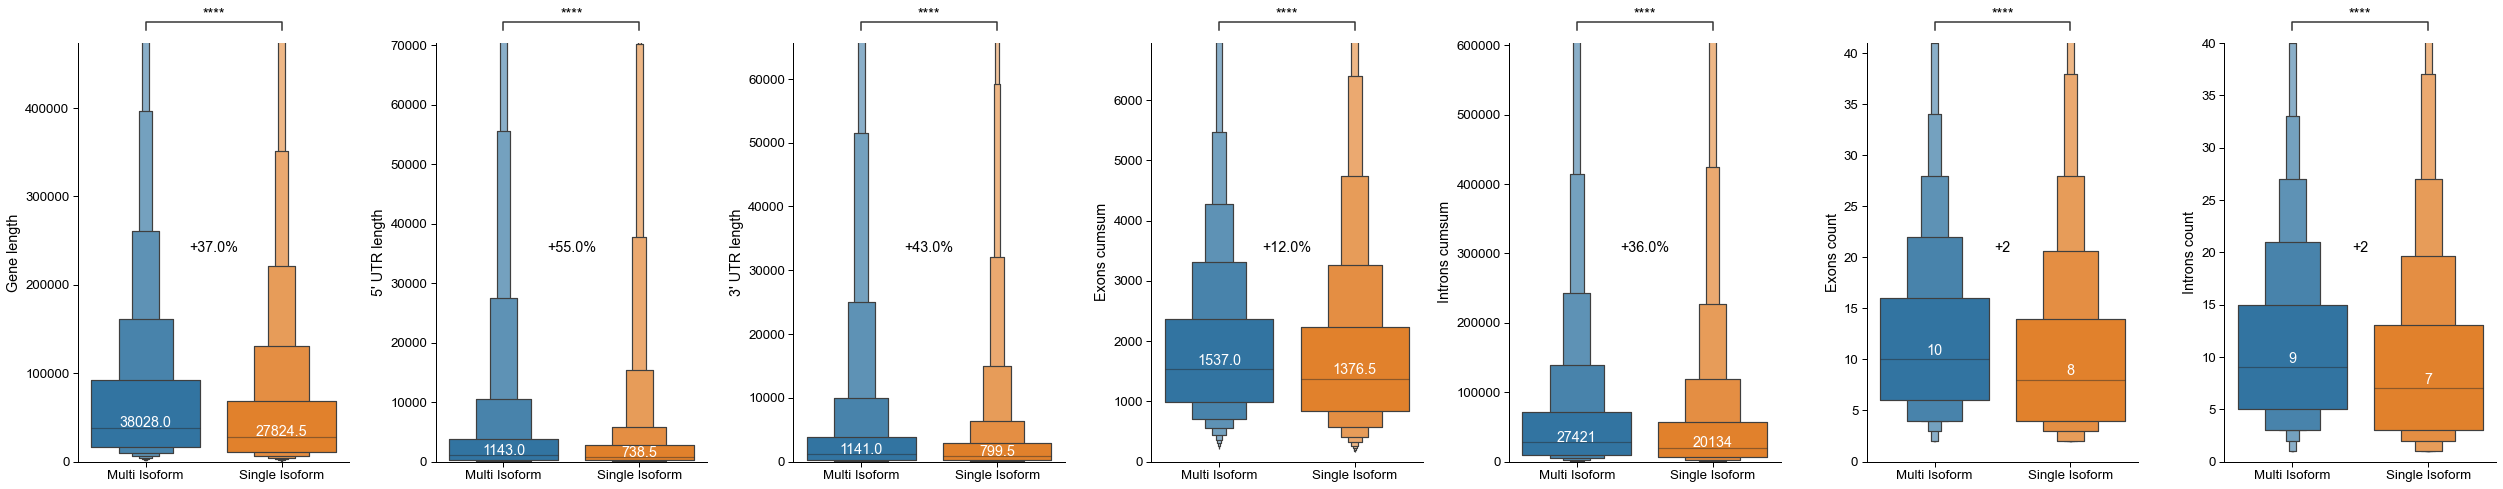

In [58]:
rename_dict = {
    'Gene_body_size' : 'Gene length',
    '5_prime_UTR_size' : "5' UTR length",
    '3_prime_UTR_size' : "3' UTR length",
    'Exon_size_total' : 'Exons cumsum',
    'Intron_size_total' : 'Introns cumsum',
    'Exon_count' : "Exons count",
    'Intron_count' : "Introns count"
}

data = refseq_corrected_full_info.rename(rename_dict, axis=1)

data = data.sort_values(by='Gene_type', ascending=True)[['Gene', 'Gene_type', 'Gene length', "5' UTR length", "3' UTR length", 'Exons cumsum', 'Introns cumsum', 'Exons count', 'Introns count']].drop_duplicates()

x_s = 'Gene_type'
y_s = ['Gene length', "5' UTR length", "3' UTR length", 'Exons cumsum', 'Introns cumsum', 'Exons count', 'Introns count']



custom_boxeplot_grid(data, x_s, y_s, {})


Index(['Gene', 'Gene_type', 'Exon count'], dtype='object')
           Gene       Gene_type  Exon count
0           A2M   Multi Isoform          38
104962    ODF2L   Multi Isoform          20
104957     ODF2   Multi Isoform          28
105009     OFD1   Multi Isoform          24
105004     ODR4   Multi Isoform          13
...         ...             ...         ...
40439     DCTN6  Single Isoform           7
111176    PHF20  Single Isoform          17
40446    DCTPP1  Single Isoform           3
40457   DCUN1D2  Single Isoform           7
40464   DCUN1D3  Single Isoform           2

[15352 rows x 3 columns]
p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

Single Isoform v.s. Multi Isoform: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.597e-236 U_stat=2.035e+07


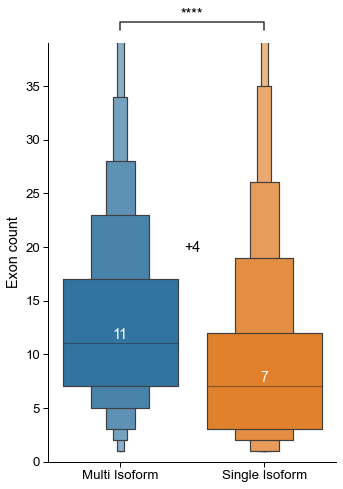

In [24]:
data = refseq_corrected_by_gtex.sort_values(by='Gene_type', ascending=True)[['Gene', 'Gene_type', 'new_CDS_count']].drop_duplicates()
custom_boxeplot(data, 'Gene_type', ['Exon count'], {'new_CDS_count' : 'Exon count'})

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

Single Isoform v.s. Multi Isoform: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.378e-179 U_stat=4.045e+09


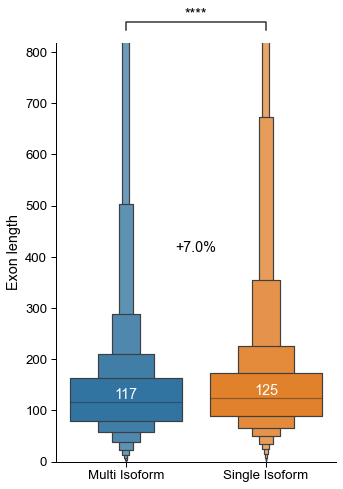

In [28]:
data = refseq_corrected_by_gtex.sort_values(by='Gene_type', ascending=True)[['Gene', 'Gene_type', 'Length']]
custom_boxeplot(data, 'Gene_type', ['Exon length'], {'Length' : 'Exon length'})

In [30]:
#data[['Gene_type', 'ranges', 'Length']].drop_duplicates().pivot(columns='Gene_type', values='Length').describe().style.highlight_max(color='#F39B7FFF', axis=1)


In [29]:
refseq_corrected_by_gtex = pd.read_parquet('/gstock/EXOTIC/data/GENOMICS/RefSeq_corrected_by_GTEx_lite.parquet')
refseq_corrected_by_gtex.loc[refseq_corrected_by_gtex['new_mRNA_nb_total'] == 1, 'Gene_type'] = 'Single Isoform'
refseq_corrected_by_gtex.loc[refseq_corrected_by_gtex['new_mRNA_nb_total'] > 1, 'Gene_type'] = 'Multi Isoform'

biomart = pd.read_csv('/gstock/EXOTIC/data/OTHERS/biomart_refseq_ensembl_hgnc.txt.gz', compression='gzip', sep='\t')

merge_biomart = pd.merge(refseq_corrected_by_gtex[['Gene', 'Gene_type']].drop_duplicates(), biomart[['Gene name', 'Gene end (bp)', 'Gene start (bp)', 'Gene type']].drop_duplicates(), left_on='Gene', right_on='Gene name')
merge_biomart.head()

/home/weber/.conda/envs/ExoCarto/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3147: DtypeWarning: Columns (14) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,Gene,Gene_type,Gene name,Gene end (bp),Gene start (bp),Gene type
0,A2M,Multi Isoform,A2M,9116229,9067664,protein_coding
1,A2ML1,Multi Isoform,A2ML1,8887001,8822621,protein_coding
2,A4GALT,Single Isoform,A4GALT,42721298,42692121,protein_coding
3,A4GNT,Single Isoform,A4GNT,138132390,138123713,protein_coding
4,AAAS,Single Isoform,AAAS,53324864,53307456,protein_coding


p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

Single Isoform v.s. Multi Isoform: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.493e-91 U_stat=2.813e+07


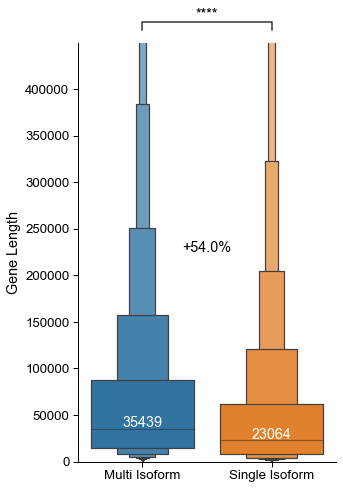

In [43]:
data = merge_biomart.sort_values(by='Gene_type', ascending=True)
data['Gene Length'] = data['Gene end (bp)'] - data['Gene start (bp)']

custom_boxeplot(data, 'Gene_type', ['Gene Length'], {})